In [74]:
import os

import pandas as pd
import psycopg2
import pyodbc
from dotenv import load_dotenv

load_dotenv()

# Pen Air creds
server = os.getenv('PENAIR_HOST')
database = os.getenv('PENAIR_DB')
username = os.getenv('PENAIR_USER')
password = os.getenv('PENAIR_PASSWORD')

# Data Lab
reader_creds = "user={} password={} host={} port={} dbname={}".format(
    os.environ["PG_USER"],
    os.environ["PG_PASSWORD"],
    os.environ["PG_HOST"],
    os.environ["PG_PORT"],
    'utility'
)

### FSA Income Data
This query will fetch the FSA income data which I put in the Data Lab a while back. It will populate a dataframe for you.

In [75]:
fsa_query = """
    SELECT *
    FROM fsa_income_2016
"""
con = psycopg2.connect(reader_creds)
fsa_df = pd.read_sql(fsa_query, con=con)

con.close()

In [76]:
fsa_df.head()

,prov_terr,fsa,total,total_income,lt20,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,gt75
0,10,A0A,40180,1670559000,1500,2320,2320,2550,2730,3090,3360,3860,4150,4110,3950,2770,3470
1,10,A0B,17860,706289000,640,970,880,820,870,1020,1400,1670,1950,2150,2030,1520,1960
2,10,A0C,11130,376387000,320,540,490,550,570,750,950,1100,1230,1320,1170,880,1260
3,10,A0E,19710,767887000,700,1100,940,1050,1150,1380,1710,1920,2020,2220,2090,1480,1960
4,10,A0G,31220,1069982000,1010,1470,1360,1400,1740,2210,2580,2980,3190,3600,3470,2590,3630


In [77]:
address_query = """
    SELECT
        FOLDERNO,
        DELIVERYADD
    FROM dbo.FolderMaster
    WHERE
        CUSTOMERNAME = 'PC Travel'
        AND LEN(DELIVERYADD) > 0
"""
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
with conn.cursor() as cur:
    cur.execute(address_query)
    results = cur.fetchall()
conn.close()

In [78]:
my_fsa = []
for folderno, address in results:
    lower_address = address.lower()
    matches = [
        fsa for fsa in fsa_df['fsa'].values
        if fsa.lower() in lower_address and address[lower_address.find(fsa.lower()) - 1].isspace()
    ]
    if len(matches) == 1:
        my_fsa.append(matches)

In [79]:
len(my_fsa)

51333

In [80]:
my_fsa = pd.DataFrame(my_fsa).rename(columns={0: 'fsa'})
my_fsa = pd.merge(my_fsa, fsa_df, on='fsa', how='left')

In [81]:
my_fsa.head()

,fsa,prov_terr,total,total_income,lt20,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,gt75
0,P0S,35,8020,343170000,300,500,540,500,490,530,640,790,950,870,750,480,690
1,N0H,35,40020,2015536000,1420,2320,2440,2520,2410,2200,2340,3230,4060,4540,4270,3170,5100
2,T6E,48,17290,995096000,290,1450,3000,2620,1760,1180,1080,1170,1120,1130,870,570,1060
3,M2N,35,71930,3197800000,1690,5790,8650,8800,7690,6820,6490,5900,4900,4050,3450,2480,5230
4,K7M,35,37080,1740232000,1250,2830,3030,2800,2510,2330,2580,3110,3140,2940,2890,2460,5210


In [82]:
my_fsa['avg_income_per_filer'] = my_fsa['total_income'] / my_fsa['total']

In [83]:
my_fsa.loc[my_fsa['fsa'] == 'M5J'].head()

,fsa,prov_terr,total,total_income,lt20,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,gt75,avg_income_per_filer
124,M5J,35,11170,992570000,140,850,2090,1840,1150,690,650,650,690,610,540,450,810,88860.340
1031,M5J,35,11170,992570000,140,850,2090,1840,1150,690,650,650,690,610,540,450,810,88860.340
1034,M5J,35,11170,992570000,140,850,2090,1840,1150,690,650,650,690,610,540,450,810,88860.340
1036,M5J,35,11170,992570000,140,850,2090,1840,1150,690,650,650,690,610,540,450,810,88860.340
1038,M5J,35,11170,992570000,140,850,2090,1840,1150,690,650,650,690,610,540,450,810,88860.340


In [15]:
my_fsa['fsa'].value_counts()[:20] / my_fsa.shape[0]

M5J    0.008635
L9T    0.006218
L5N    0.005224
M2N    0.005127
T3K    0.005049
T2Z    0.004990
L5M    0.004932
T3H    0.004873
T6W    0.004815
M5V    0.004522
Name: fsa, dtype: float64

In [18]:
my_fsa.groupby('fsa') \
       .agg({'prov_terr':'size', 'avg_income_per_filer': 'mean'}) \
       .rename(columns={'prov_terr':'count'}) \
       .reset_index().sort_values('count', ascending=False).head(20)

,fsa,count,avg_income_per_filer
778,M5J,443,88860.340197
713,L9T,319,51366.404525
645,L5N,268,47403.591824
741,M2N,263,44457.111080
1152,T3K,259,49977.098222
1144,T2Z,256,62867.379256
644,L5M,253,45588.038336
1150,T3H,250,89154.161162
1208,T6W,247,63540.403286
786,M5V,232,74425.006686


In [19]:
my_fsa.groupby('fsa') \
       .agg({'prov_terr':'size', 'avg_income_per_filer': 'mean'}) \
       .rename(columns={'prov_terr':'count'}) \
       .reset_index().sort_values('avg_income_per_filer', ascending=False).head(20)

,fsa,count,avg_income_per_filer
787,M5X,1,285600.000000
779,M5K,3,234220.689655
495,K1P,2,212351.470588
763,M4N,24,186354.545455
769,M4W,55,178655.788591
767,M4T,29,160458.279570
1158,T3Z,15,148801.157407
777,M5H,10,146701.094891
768,M4V,49,137009.567039
774,M5C,23,133594.252874


In [20]:
new_df = my_fsa.groupby('fsa') \
       .agg({'prov_terr':'size', 'avg_income_per_filer': 'mean'}) \
       .rename(columns={'prov_terr':'count'}) \
       .reset_index().sort_values('count', ascending=False)

In [23]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,1431.0,35.850454,43.403103,1.000000,5.000000,20.000000,53.00000,443.0
avg_income_per_filer,1431.0,49498.859902,18702.711169,12637.245808,39275.672388,45478.082192,54522.63822,285600.0


In [85]:
my_fsa[['avg_income_per_filer']].describe()

,avg_income_per_filer
count,51333.000
mean,51619.202
std,16024.945
min,12637.246
25%,41965.333
50%,48438.492
75%,57814.470
max,285600.000


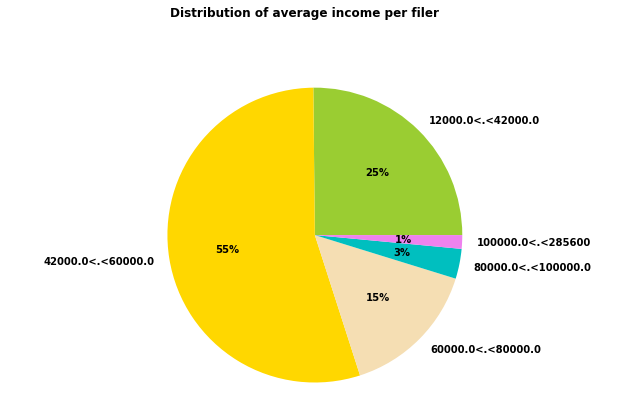

In [88]:
income_range = [12000.00, 42000.00, 60000.00, 80000.00, 100000.00, 285600]
count_income = []
for i, income in enumerate(income_range):
    if i == 0: continue
    val = my_fsa[(my_fsa['avg_income_per_filer'] < income) &
                       (my_fsa['avg_income_per_filer'] > income_range[i-1])]['avg_income_per_filer'].count()
    count_income.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(income_range[i-1], s) for i,s in enumerate(income_range) if i != 0]
sizes  = count_income
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of average income per filer", ha='center', fontsize = 12);

In [89]:
my_fsa.loc[my_fsa['fsa'] == 'M5J'][['lt20', '20_24', '25_29', '30_34', '35_39', 
        '40_44', '45_49', '50_54', '55_59', '60_64', '65_69', '70_74', 'gt75']].cumsum(axis = 1)

,lt20,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,gt75
124,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
1031,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
1034,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
1036,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
1038,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50446,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
50650,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
50778,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160
50827,140,990,3080,4920,6070,6760,7410,8060,8750,9360,9900,10350,11160


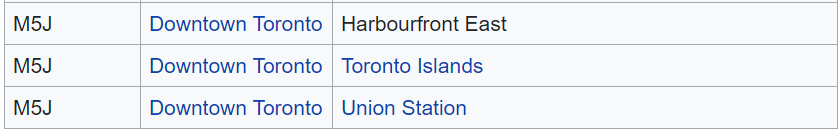

### Notes
The algorithm sometimes returns 0 matches and sometimes returns more than 1. 0 is not a big deal. Not all data has addresses. The question of what to do when there are multiple matches is tricky. Luckily, there are only a handful. I would just drop them.